In [1]:
import sys
sys.path.append('../..')

In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
from scipy import interpolate

import random
import tqdm
from copy import deepcopy
from argparse import Namespace
import warnings

%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

In [3]:
# from causal_meta.modules import networks as nets
from causal_meta.utils.data_utils import RandomSplineSCM

from causal_meta.utils import train_utils as tu
from encoder import Rotor
from causal_meta.modules.mdn import MDN, GMM, mdn_nll
from causal_meta.modules.gmm import GaussianMixture

In [4]:
SEED = 91023
torch.manual_seed(SEED)
np.random.seed(SEED)

# Boilerplate

## Utilities

In [5]:
def normal(mean, std, N): 
    return torch.normal(torch.ones(N).mul_(mean), torch.ones(N).mul_(std)).view(-1, 1)

def normal_like(X): 
    mean = X.mean()
    std = X.std()
    return normal(mean, std, X.size(0))

def mlp(opt): 
    if opt.NUM_MID_LAYERS == -1: 
        return nn.Linear(opt.INP_DIM, opt.OUT_DIM)
    else:
        return nets.MLP(opt.INP_DIM, opt.OUT_DIM, opt.NUM_MID_LAYERS, 
                        opt.CAPACITY, opt.INP_NOISE)

## Mixture Density

In [6]:
def mdn(opt): 
    return MDN(opt.CAPACITY, opt.NUM_COMPONENTS)

def gmm(opt): 
    return GaussianMixture(opt.GMM_NUM_COMPONENTS)

## Reversible Encoder

In [7]:
def xcodergen(opt): 
    # Make rotor
    return Rotor(opt.XCODER_INIT)

## Ground Truth Generator

We use a posterior of the form: 

$$
P(Y | X) = \sum_i \pi_i(X) \mathcal{N}(\mu_i(X), \sigma_i(X))
$$

which is a mixture of 10 gaussians. 

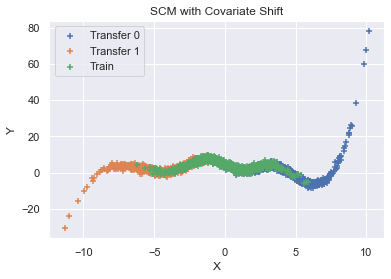

In [8]:
# Test
rand_scm = RandomSplineSCM(False, True, 8, 8, 3, range_scale=1.)

plt.figure()
plt.title("SCM with Covariate Shift")
rand_scm.plot(X=normal(4, 2, 1000), show=False, label='Transfer 0')
rand_scm.plot(X=normal(-4, 2, 1000), show=False, label='Transfer 1')
rand_scm.plot(X=normal(0, 2, 1000), show=False, label='Train')
plt.xlabel("X")
plt.ylabel("Y")
plt.legend()
plt.show()

## Visualization

In [9]:
def plot_key(frames, key, show=True, label=None, name=None): 
    its, vals = zip(*[(frame.iter_num, getattr(frame, key)) for frame in frames])
    if show:
        plt.figure()
    plt.plot(its, vals, label=label)
    if show:
        plt.xlabel("Iterations")
        plt.ylabel(name if name is not None else key.title())
        plt.show()

## Training

In [10]:
def gradnan_filter(model): 
    nan_found = False
    for p in model.parameters(): 
        nan_mask = torch.isnan(p.grad.data)
        nan_found = bool(nan_mask.any().item())
        p.grad.data[nan_mask] = 0.
    return nan_found

In [11]:
def marginal_nll(opt, inp, nll): 
    model_g = gmm(opt)
    if opt.CUDA: 
        model_g = model_g.cuda()
    model_g.fit(inp, n_iter=opt.EM_ITERS)
    with torch.no_grad():
        loss_marginal = nll(model_g(inp), inp)
    return loss_marginal

In [22]:
def encoder_train_shared_regret(opt, model_x2y, model_y2x, scm, encoder, decoder, alpha): 
    if opt.CUDA: 
        model_x2y = model_x2y.cuda()
        model_y2x = model_y2x.cuda()
        encoder = encoder.cuda()
        decoder = decoder.cuda()
    encoder_optim = torch.optim.Adam(encoder.parameters(), opt.ENCODER_LR)
    alpha_optim = torch.optim.Adam([alpha], opt.ALPHA_LR)
    frames = []
    for meta_iter in tqdm.trange(opt.NUM_META_ITER): 
        # Preheat the models
        _ = tu.train_nll(opt, model_x2y, scm, opt.TRAIN_DISTRY, 'X2Y', 
                         mdn_nll, decoder, encoder)
        _ = tu.train_nll(opt, model_y2x, scm, opt.TRAIN_DISTRY, 'Y2X', 
                         mdn_nll, decoder, encoder)
        # Sample from SCM
        X = opt.TRANS_DISTRY()
        Y = scm(X)
        if opt.CUDA: 
            X, Y = X.cuda(), Y.cuda()
        # Decode 
        with torch.no_grad(): 
            X, Y = decoder(X, Y)
        # Encode
        X, Y = encoder(X, Y)
        with torch.no_grad():
            if opt.USE_BASELINE:
                baseline_y = marginal_nll(opt, Y, mdn_nll)
                baseline_x = marginal_nll(opt, X, mdn_nll)
            else:
                baseline_y = 0.
                baseline_x = 0.
        # Save state dicts
        state_x2y = deepcopy(model_x2y.state_dict())
        state_y2x = deepcopy(model_y2x.state_dict())
        # Inner loop 
        optim_x2y = torch.optim.Adam(model_x2y.parameters(), lr=opt.FINETUNE_LR)
        optim_y2x = torch.optim.Adam(model_y2x.parameters(), lr=opt.FINETUNE_LR)
        regrets_x2y = []
        regrets_y2x = []
        is_nan = False
        # Evaluate regret discrepancy 
        for t in range(opt.FINETUNE_NUM_ITER):
            loss_x2y = mdn_nll(model_x2y(X), Y)
            loss_y2x = mdn_nll(model_y2x(Y), X)
            if torch.isnan(loss_x2y).item() or torch.isnan(loss_y2x).item(): 
                is_nan = True
                break
            optim_x2y.zero_grad()
            optim_y2x.zero_grad()
            loss_x2y.backward(retain_graph=True) 
            loss_y2x.backward(retain_graph=True)
            # Filter out NaNs that might have sneaked in
            nan_in_x2y = gradnan_filter(model_x2y)
            nan_in_y2x = gradnan_filter(model_y2x)
            if nan_in_x2y or nan_in_y2x: 
                is_nan = True
                break
            optim_x2y.step()
            optim_y2x.step()
            # Store for encoder
            regrets_x2y.append(loss_x2y + baseline_x)
            regrets_y2x.append(loss_y2x + baseline_y)
        if not is_nan:
            # Evaluate total regret
            regret_x2y = torch.stack(regrets_x2y).mean()
            regret_y2x = torch.stack(regrets_y2x).mean()
            # Evaluate losses
            loss = torch.logsumexp(
                torch.stack([F.logsigmoid(alpha) + regret_x2y,
                             F.logsigmoid(-alpha) + regret_y2x]), 
                0)
            # Optimize
            encoder_optim.zero_grad()
            alpha_optim.zero_grad()
            loss.backward()
            # Make sure no nans
            if torch.isnan(encoder.theta.grad.data).any(): 
                encoder.theta.grad.data.zero_()
            if torch.isnan(alpha.grad.data).any(): 
                alpha.grad.data.zero_()
            encoder_optim.step()
            alpha_optim.step()
            # Load original state dicts
            model_x2y.load_state_dict(state_x2y)
            model_y2x.load_state_dict(state_y2x)
            # Add info
            frames.append(Namespace(iter_num=meta_iter, 
                                    regret_x2y=regret_x2y.item(), 
                                    regret_y2x=regret_y2x.item(),
                                    loss=loss.item(),
                                    alpha=alpha.item(), 
                                    theta=encoder.theta.item()))
        else:
            # Load original state dicts
            model_x2y.load_state_dict(state_x2y)
            model_y2x.load_state_dict(state_y2x)
            # Add dummy info
            frames.append(Namespace(iter_num=meta_iter, 
                                    regret_x2y=float('nan'), 
                                    regret_y2x=float('nan'),
                                    loss=float('nan'),
                                    alpha=float('nan'), 
                                    theta=float('nan')))
            
    return frames

In [13]:
def plot_theta(frames, gt_theta, save=False): 
    its, vals = zip(*[(frame.iter_num, frame.theta / (np.pi / 2)) for frame in frames])
    gt_theta = -gt_theta.item() / (np.pi / 2)
    plt.figure()
    # plt.plot(its, vals, label=r'$\theta_{\mathcal{E}}$', c='black')
    plt.plot(its, vals, label=r'$\theta_{\mathcal{E}}$')
    plt.plot(its, [gt_theta] * len(its), linestyle='--', label=r'Solution 1 $\left(+\frac{\pi}{4}\right)$')
    plt.plot(its, [gt_theta - 1] * len(its), linestyle='--', label=r'Solution 2 $\left(-\frac{\pi}{4}\right)$')
    plt.xlabel("Iterations")
    plt.ylabel("Encoder Angle [π/2 rad]")
    plt.legend()
    if save:
        plt.savefig('fixed-encoder-evo.pdf', bbox_inches='tight', format='pdf')
    plt.show()

In [14]:
def probe_xcoders(encoder, decoder):
    # Test encoder and decoder
    with torch.no_grad():
        _X = torch.tensor([[1.]])
        _Y = torch.tensor([[0.]])
        if opt.CUDA:
            _X, _Y = _X.to(encoder.theta.device), _Y.to(encoder.theta.device)
        _X_d, _Y_d = decoder(_X, _Y)
        _X_de, _Y_de = encoder(_X_d, _Y_d)
    print(f"Initial (A, B) = {_X.item()}, {_Y.item()}")
    print(f"Decoded (X, Y) = {_X_d.item()}, {_Y_d.item()}")
    print(f"Encoded (U, V) = {_X_de.item()}, {_Y_de.item()}")

# Experiments with Unfixed Encoders

In [15]:
opt = Namespace()

# Model
opt.CAPACITY = 32
opt.NUM_COMPONENTS = 10
opt.GMM_NUM_COMPONENTS = 10

# Training
opt.LR = 0.01
opt.NUM_ITER = 20
opt.NUM_META_ITER = 1000
opt.ENCODER_LR = 0.01
opt.ALPHA_LR = 0.001
opt.CUDA = False #sTrue
opt.REC_FREQ = 10
opt.ALPHA_INIT = 0.
opt.USE_BASELINE = True

# Fine tuning
opt.FINETUNE_NUM_ITER = 5
opt.FINETUNE_LR = 0.001
opt.EM_ITERS = 500

# Sampling 
opt.NUM_SAMPLES = 1000
opt.TRAIN_DISTRY = lambda: normal(0, 2, opt.NUM_SAMPLES)
opt.TRANS_DISTRY = lambda: normal(np.random.uniform(-4, 4), 
                                  2, opt.NUM_SAMPLES)

# Encoder
opt.DECODER_DEFAULT = -float(0.5 * np.pi/2)

## Make Xcoders

Make a ground-truth decoder with $\theta_0$. 

In [16]:
gt_decoder = Rotor(opt.DECODER_DEFAULT)

The real encoder should have $\theta = -\theta_0$. 

In [17]:
encoder = Rotor(0. * np.pi/2)

In [18]:
probe_xcoders(encoder, gt_decoder)

Initial (A, B) = 1.0, 0.0
Decoded (X, Y) = 0.7071067690849304, 0.7071067690849304
Encoded (U, V) = 0.7071067690849304, 0.7071067690849304


## Make Alpha and Models

In [19]:
alpha = tu.make_alpha(opt)

In [20]:
model_x2y = mdn(opt)
model_y2x = mdn(opt)

## Train Encoder

If it doesn't work with the seed of your choice, try tuning the (hyper)parameters of ```opt.TRANS_DISTRY```. Since the SCM is generated randomly, it's not possible to know the correct hyper-parameters in advance (unless the seed is fixed). $\sigma \in (1, 2)$ should work fine, but if the range from which the means are sampled is too large, you can have numerical instabilities. If it's too small, the gradient signal to the encoder can be weak. 

In [23]:
frames = encoder_train_shared_regret(opt, model_x2y, model_y2x, rand_scm, encoder, gt_decoder, alpha)

  0%|          | 0/1000 [00:00<?, ?it/s]

  0%|          | 1/1000 [00:01<19:15,  1.16s/it]

  0%|          | 2/1000 [00:01<17:10,  1.03s/it]

  0%|          | 3/1000 [00:02<16:49,  1.01s/it]

  0%|          | 4/1000 [00:03<15:39,  1.06it/s]

  0%|          | 5/1000 [00:04<15:13,  1.09it/s]

  1%|          | 6/1000 [00:05<14:51,  1.11it/s]

  1%|          | 7/1000 [00:06<15:23,  1.08it/s]

  1%|          | 8/1000 [00:07<14:24,  1.15it/s]

  1%|          | 9/1000 [00:07<13:26,  1.23it/s]

  1%|          | 10/1000 [00:08<13:12,  1.25it/s]

  1%|          | 11/1000 [00:09<14:07,  1.17it/s]

  1%|          | 12/1000 [00:10<14:20,  1.15it/s]

  1%|▏         | 13/1000 [00:11<15:07,  1.09it/s]

  1%|▏         | 14/1000 [00:12<14:29,  1.13it/s]

  2%|▏         | 15/1000 [00:13<14:06,  1.16it/s]

  2%|▏         | 16/1000 [00:13<13:53,  1.18it/s]

  2%|▏         | 17/1000 [00:14<14:25,  1.14it/s]

  2%|▏         | 18/1000 [00:15<14:16,  1.15it/s]

  2%|▏         | 19/1000 [00:16<14:01,  1.17it/s]

  2%|▏         | 20/1000 [00:17<13:37,  1.20it/s]

  2%|▏         | 21/1000 [00:18<14:08,  1.15it/s]

  2%|▏         | 22/1000 [00:19<14:55,  1.09it/s]

  2%|▏         | 23/1000 [00:19<13:53,  1.17it/s]

  2%|▏         | 24/1000 [00:20<14:18,  1.14it/s]

  2%|▎         | 25/1000 [00:21<14:41,  1.11it/s]

  3%|▎         | 26/1000 [00:22<14:27,  1.12it/s]

  3%|▎         | 27/1000 [00:23<14:44,  1.10it/s]

  3%|▎         | 28/1000 [00:24<14:31,  1.12it/s]

  3%|▎         | 29/1000 [00:26<19:42,  1.22s/it]

  3%|▎         | 30/1000 [00:27<18:58,  1.17s/it]

  3%|▎         | 31/1000 [00:28<17:54,  1.11s/it]

  3%|▎         | 32/1000 [00:29<18:03,  1.12s/it]

  3%|▎         | 33/1000 [00:30<17:42,  1.10s/it]

  3%|▎         | 34/1000 [00:32<18:56,  1.18s/it]

  4%|▎         | 35/1000 [00:33<18:32,  1.15s/it]

  4%|▎         | 36/1000 [00:34<17:41,  1.10s/it]

  4%|▎         | 37/1000 [00:34<15:47,  1.02it/s]

  4%|▍         | 38/1000 [00:35<15:09,  1.06it/s]

  4%|▍         | 39/1000 [00:36<16:07,  1.01s/it]

  4%|▍         | 40/1000 [00:37<16:06,  1.01s/it]

  4%|▍         | 41/1000 [00:38<14:06,  1.13it/s]

  4%|▍         | 42/1000 [00:39<12:59,  1.23it/s]

  4%|▍         | 43/1000 [00:40<13:16,  1.20it/s]

  4%|▍         | 44/1000 [00:40<12:09,  1.31it/s]

  4%|▍         | 45/1000 [00:41<12:36,  1.26it/s]

  5%|▍         | 46/1000 [00:42<12:32,  1.27it/s]

  5%|▍         | 47/1000 [00:43<12:55,  1.23it/s]

  5%|▍         | 48/1000 [00:44<13:09,  1.21it/s]

  5%|▍         | 49/1000 [00:44<13:39,  1.16it/s]

  5%|▌         | 50/1000 [00:45<13:47,  1.15it/s]

  5%|▌         | 51/1000 [00:46<13:47,  1.15it/s]

  5%|▌         | 52/1000 [00:47<13:41,  1.15it/s]

  5%|▌         | 53/1000 [00:48<13:46,  1.15it/s]

  5%|▌         | 54/1000 [00:49<13:40,  1.15it/s]

  6%|▌         | 55/1000 [00:50<14:02,  1.12it/s]

  6%|▌         | 56/1000 [00:51<14:09,  1.11it/s]

  6%|▌         | 57/1000 [00:52<13:47,  1.14it/s]

  6%|▌         | 58/1000 [00:52<13:42,  1.15it/s]

  6%|▌         | 59/1000 [00:53<14:03,  1.12it/s]

  6%|▌         | 60/1000 [00:54<13:02,  1.20it/s]

  6%|▌         | 61/1000 [00:55<13:19,  1.17it/s]

  6%|▌         | 62/1000 [00:56<12:58,  1.20it/s]

  6%|▋         | 63/1000 [00:56<12:50,  1.22it/s]

  6%|▋         | 64/1000 [00:57<11:59,  1.30it/s]

  6%|▋         | 65/1000 [00:58<12:12,  1.28it/s]

  7%|▋         | 66/1000 [00:59<12:09,  1.28it/s]

  7%|▋         | 67/1000 [00:59<11:51,  1.31it/s]

  7%|▋         | 68/1000 [01:00<11:55,  1.30it/s]

  7%|▋         | 69/1000 [01:01<12:38,  1.23it/s]

  7%|▋         | 70/1000 [01:02<12:55,  1.20it/s]

  7%|▋         | 71/1000 [01:03<13:18,  1.16it/s]

  7%|▋         | 72/1000 [01:04<13:08,  1.18it/s]

  7%|▋         | 73/1000 [01:05<13:52,  1.11it/s]

  7%|▋         | 74/1000 [01:06<13:38,  1.13it/s]

  8%|▊         | 75/1000 [01:06<12:27,  1.24it/s]

  8%|▊         | 76/1000 [01:07<12:29,  1.23it/s]

  8%|▊         | 77/1000 [01:08<13:45,  1.12it/s]

  8%|▊         | 78/1000 [01:09<14:02,  1.09it/s]

  8%|▊         | 79/1000 [01:10<14:05,  1.09it/s]

  8%|▊         | 80/1000 [01:11<13:37,  1.13it/s]

  8%|▊         | 81/1000 [01:12<14:05,  1.09it/s]

  8%|▊         | 82/1000 [01:13<12:52,  1.19it/s]

  8%|▊         | 83/1000 [01:14<13:35,  1.12it/s]

  8%|▊         | 84/1000 [01:14<13:11,  1.16it/s]

  8%|▊         | 85/1000 [01:15<13:24,  1.14it/s]

  9%|▊         | 86/1000 [01:16<13:23,  1.14it/s]

  9%|▊         | 87/1000 [01:17<12:33,  1.21it/s]

  9%|▉         | 88/1000 [01:18<12:36,  1.21it/s]

  9%|▉         | 89/1000 [01:19<13:19,  1.14it/s]

  9%|▉         | 90/1000 [01:19<12:42,  1.19it/s]

  9%|▉         | 91/1000 [01:20<13:16,  1.14it/s]

  9%|▉         | 92/1000 [01:21<13:07,  1.15it/s]

  9%|▉         | 93/1000 [01:22<12:35,  1.20it/s]

  9%|▉         | 94/1000 [01:23<13:16,  1.14it/s]

 10%|▉         | 95/1000 [01:24<12:51,  1.17it/s]

 10%|▉         | 96/1000 [01:25<13:26,  1.12it/s]

 10%|▉         | 97/1000 [01:26<13:37,  1.10it/s]

 10%|▉         | 98/1000 [01:27<13:21,  1.13it/s]

 10%|▉         | 99/1000 [01:27<13:28,  1.11it/s]

 10%|█         | 100/1000 [01:28<13:05,  1.15it/s]

 10%|█         | 101/1000 [01:29<12:35,  1.19it/s]

 10%|█         | 102/1000 [01:30<13:11,  1.13it/s]

 10%|█         | 103/1000 [01:31<13:00,  1.15it/s]

 10%|█         | 104/1000 [01:32<13:14,  1.13it/s]

 10%|█         | 105/1000 [01:32<12:16,  1.21it/s]

 11%|█         | 106/1000 [01:33<11:58,  1.24it/s]

 11%|█         | 107/1000 [01:34<12:12,  1.22it/s]

 11%|█         | 108/1000 [01:35<12:15,  1.21it/s]

 11%|█         | 109/1000 [01:36<12:30,  1.19it/s]

 11%|█         | 110/1000 [01:36<11:39,  1.27it/s]

 11%|█         | 111/1000 [01:37<12:24,  1.19it/s]

 11%|█         | 112/1000 [01:38<12:40,  1.17it/s]

 11%|█▏        | 113/1000 [01:39<13:11,  1.12it/s]

 11%|█▏        | 114/1000 [01:40<12:20,  1.20it/s]

 12%|█▏        | 115/1000 [01:41<12:24,  1.19it/s]

 12%|█▏        | 116/1000 [01:42<13:02,  1.13it/s]

 12%|█▏        | 117/1000 [01:43<13:16,  1.11it/s]

 12%|█▏        | 118/1000 [01:43<12:36,  1.17it/s]

 12%|█▏        | 119/1000 [01:44<13:12,  1.11it/s]

 12%|█▏        | 120/1000 [01:45<12:21,  1.19it/s]

 12%|█▏        | 121/1000 [01:46<12:50,  1.14it/s]

 12%|█▏        | 122/1000 [01:47<12:35,  1.16it/s]

 12%|█▏        | 123/1000 [01:48<12:53,  1.13it/s]

 12%|█▏        | 124/1000 [01:49<12:12,  1.20it/s]

 12%|█▎        | 125/1000 [01:50<12:36,  1.16it/s]

 13%|█▎        | 126/1000 [01:51<12:57,  1.12it/s]

 13%|█▎        | 127/1000 [01:51<12:14,  1.19it/s]

 13%|█▎        | 128/1000 [01:52<12:52,  1.13it/s]

 13%|█▎        | 129/1000 [01:53<12:06,  1.20it/s]

 13%|█▎        | 130/1000 [01:54<12:08,  1.19it/s]

 13%|█▎        | 131/1000 [01:55<11:39,  1.24it/s]

 13%|█▎        | 132/1000 [01:55<11:37,  1.24it/s]

 13%|█▎        | 133/1000 [01:56<11:48,  1.22it/s]

 13%|█▎        | 134/1000 [01:57<11:55,  1.21it/s]

 14%|█▎        | 135/1000 [01:58<11:39,  1.24it/s]

 14%|█▎        | 136/1000 [01:58<10:10,  1.42it/s]

 14%|█▎        | 137/1000 [01:59<10:28,  1.37it/s]

 14%|█▍        | 138/1000 [02:00<11:05,  1.29it/s]

 14%|█▍        | 139/1000 [02:01<11:54,  1.21it/s]

 14%|█▍        | 140/1000 [02:02<12:20,  1.16it/s]

 14%|█▍        | 141/1000 [02:03<12:43,  1.12it/s]

 14%|█▍        | 142/1000 [02:03<11:45,  1.22it/s]

 14%|█▍        | 143/1000 [02:04<11:34,  1.23it/s]

 14%|█▍        | 144/1000 [02:05<12:10,  1.17it/s]

 14%|█▍        | 145/1000 [02:06<12:08,  1.17it/s]

 15%|█▍        | 146/1000 [02:07<12:35,  1.13it/s]

 15%|█▍        | 147/1000 [02:08<11:53,  1.19it/s]

 15%|█▍        | 148/1000 [02:09<12:04,  1.18it/s]

 15%|█▍        | 149/1000 [02:10<13:05,  1.08it/s]

 15%|█▌        | 150/1000 [02:11<13:02,  1.09it/s]

 15%|█▌        | 151/1000 [02:12<13:30,  1.05it/s]

 15%|█▌        | 152/1000 [02:13<14:01,  1.01it/s]

 15%|█▌        | 153/1000 [02:14<13:24,  1.05it/s]

 15%|█▌        | 154/1000 [02:15<14:31,  1.03s/it]

 16%|█▌        | 155/1000 [02:16<13:51,  1.02it/s]

 16%|█▌        | 156/1000 [02:17<14:50,  1.06s/it]

 16%|█▌        | 157/1000 [02:18<15:09,  1.08s/it]

 16%|█▌        | 158/1000 [02:19<15:33,  1.11s/it]

 16%|█▌        | 159/1000 [02:20<15:29,  1.11s/it]

 16%|█▌        | 160/1000 [02:21<15:10,  1.08s/it]

 16%|█▌        | 161/1000 [02:22<14:59,  1.07s/it]

 16%|█▌        | 162/1000 [02:23<13:33,  1.03it/s]

 16%|█▋        | 163/1000 [02:24<13:16,  1.05it/s]

 16%|█▋        | 164/1000 [02:25<12:43,  1.10it/s]

 16%|█▋        | 165/1000 [02:26<12:00,  1.16it/s]

 17%|█▋        | 166/1000 [02:27<12:20,  1.13it/s]

 17%|█▋        | 167/1000 [02:28<12:47,  1.09it/s]

 17%|█▋        | 168/1000 [02:28<12:53,  1.08it/s]

 17%|█▋        | 169/1000 [02:29<12:08,  1.14it/s]

 17%|█▋        | 170/1000 [02:30<12:29,  1.11it/s]

 17%|█▋        | 171/1000 [02:31<12:42,  1.09it/s]

 17%|█▋        | 172/1000 [02:32<12:21,  1.12it/s]

 17%|█▋        | 173/1000 [02:33<11:40,  1.18it/s]

 17%|█▋        | 174/1000 [02:34<12:14,  1.12it/s]

 18%|█▊        | 175/1000 [02:35<12:48,  1.07it/s]

 18%|█▊        | 176/1000 [02:36<12:05,  1.14it/s]

 18%|█▊        | 177/1000 [02:36<11:53,  1.15it/s]

 18%|█▊        | 178/1000 [02:37<12:22,  1.11it/s]

 18%|█▊        | 179/1000 [02:38<12:31,  1.09it/s]

 18%|█▊        | 180/1000 [02:39<12:45,  1.07it/s]

 18%|█▊        | 181/1000 [02:40<12:47,  1.07it/s]

 18%|█▊        | 182/1000 [02:41<13:24,  1.02it/s]

 18%|█▊        | 183/1000 [02:42<13:02,  1.04it/s]

 18%|█▊        | 184/1000 [02:43<13:16,  1.02it/s]

 18%|█▊        | 185/1000 [02:44<12:34,  1.08it/s]

 19%|█▊        | 186/1000 [02:45<12:51,  1.05it/s]

 19%|█▊        | 187/1000 [02:46<12:39,  1.07it/s]

 19%|█▉        | 188/1000 [02:47<12:17,  1.10it/s]

 19%|█▉        | 189/1000 [02:47<11:13,  1.20it/s]

 19%|█▉        | 190/1000 [02:48<11:51,  1.14it/s]

 19%|█▉        | 191/1000 [02:49<12:04,  1.12it/s]

 19%|█▉        | 192/1000 [02:50<12:12,  1.10it/s]

 19%|█▉        | 193/1000 [02:51<12:49,  1.05it/s]

 19%|█▉        | 194/1000 [02:52<13:02,  1.03it/s]

 20%|█▉        | 195/1000 [02:53<13:16,  1.01it/s]

 20%|█▉        | 196/1000 [02:54<12:39,  1.06it/s]

 20%|█▉        | 197/1000 [02:55<12:28,  1.07it/s]

 20%|█▉        | 198/1000 [02:56<13:25,  1.00s/it]

 20%|█▉        | 199/1000 [02:58<14:24,  1.08s/it]

 20%|██        | 200/1000 [02:59<14:54,  1.12s/it]

 20%|██        | 201/1000 [03:00<14:19,  1.08s/it]

 20%|██        | 202/1000 [03:01<13:42,  1.03s/it]

 20%|██        | 203/1000 [03:01<12:33,  1.06it/s]

 20%|██        | 204/1000 [03:02<12:26,  1.07it/s]

 20%|██        | 205/1000 [03:03<11:39,  1.14it/s]

 21%|██        | 206/1000 [03:04<10:54,  1.21it/s]

 21%|██        | 207/1000 [03:05<10:38,  1.24it/s]

 21%|██        | 208/1000 [03:06<11:23,  1.16it/s]

 21%|██        | 209/1000 [03:06<11:26,  1.15it/s]

 21%|██        | 210/1000 [03:07<11:56,  1.10it/s]

 21%|██        | 211/1000 [03:08<12:11,  1.08it/s]

 21%|██        | 212/1000 [03:09<11:25,  1.15it/s]

 21%|██▏       | 213/1000 [03:10<11:55,  1.10it/s]

 21%|██▏       | 214/1000 [03:11<11:20,  1.15it/s]

 22%|██▏       | 215/1000 [03:12<11:57,  1.09it/s]

 22%|██▏       | 216/1000 [03:13<11:06,  1.18it/s]

 22%|██▏       | 217/1000 [03:14<12:33,  1.04it/s]

 22%|██▏       | 218/1000 [03:15<12:21,  1.05it/s]

 22%|██▏       | 219/1000 [03:16<12:38,  1.03it/s]

 22%|██▏       | 220/1000 [03:17<13:00,  1.00s/it]

 22%|██▏       | 221/1000 [03:18<12:53,  1.01it/s]

 22%|██▏       | 222/1000 [03:18<10:54,  1.19it/s]

 22%|██▏       | 223/1000 [03:19<10:48,  1.20it/s]

 22%|██▏       | 224/1000 [03:20<10:49,  1.20it/s]

 22%|██▎       | 225/1000 [03:21<09:59,  1.29it/s]

 23%|██▎       | 226/1000 [03:21<10:07,  1.27it/s]

 23%|██▎       | 227/1000 [03:22<10:14,  1.26it/s]

 23%|██▎       | 228/1000 [03:23<10:23,  1.24it/s]

 23%|██▎       | 229/1000 [03:24<10:14,  1.25it/s]

 23%|██▎       | 230/1000 [03:25<10:21,  1.24it/s]

 23%|██▎       | 231/1000 [03:28<18:44,  1.46s/it]

 23%|██▎       | 232/1000 [03:29<17:00,  1.33s/it]

 23%|██▎       | 233/1000 [03:30<15:33,  1.22s/it]

 23%|██▎       | 234/1000 [03:30<14:05,  1.10s/it]

 24%|██▎       | 235/1000 [03:31<12:31,  1.02it/s]

 24%|██▎       | 236/1000 [03:32<12:34,  1.01it/s]

 24%|██▎       | 237/1000 [03:33<11:48,  1.08it/s]

 24%|██▍       | 238/1000 [03:34<10:42,  1.19it/s]

 24%|██▍       | 239/1000 [03:34<10:28,  1.21it/s]

 24%|██▍       | 240/1000 [03:35<10:59,  1.15it/s]

 24%|██▍       | 241/1000 [03:36<11:37,  1.09it/s]

 24%|██▍       | 242/1000 [03:37<11:49,  1.07it/s]

 24%|██▍       | 243/1000 [03:38<12:22,  1.02it/s]

 24%|██▍       | 244/1000 [03:39<12:21,  1.02it/s]

 24%|██▍       | 245/1000 [03:40<12:07,  1.04it/s]

 25%|██▍       | 246/1000 [03:41<12:09,  1.03it/s]

 25%|██▍       | 247/1000 [03:42<11:46,  1.07it/s]

 25%|██▍       | 248/1000 [03:43<11:55,  1.05it/s]

 25%|██▍       | 249/1000 [03:44<11:07,  1.13it/s]

 25%|██▌       | 250/1000 [03:45<10:58,  1.14it/s]

 25%|██▌       | 251/1000 [03:46<11:14,  1.11it/s]

 25%|██▌       | 252/1000 [03:47<11:18,  1.10it/s]

 25%|██▌       | 253/1000 [03:48<11:26,  1.09it/s]

 25%|██▌       | 254/1000 [03:49<11:24,  1.09it/s]

 26%|██▌       | 255/1000 [03:49<10:05,  1.23it/s]

 26%|██▌       | 256/1000 [03:50<10:18,  1.20it/s]

 26%|██▌       | 257/1000 [03:51<10:38,  1.16it/s]

 26%|██▌       | 258/1000 [03:52<10:44,  1.15it/s]

 26%|██▌       | 259/1000 [03:53<11:00,  1.12it/s]

 26%|██▌       | 260/1000 [03:54<11:08,  1.11it/s]

 26%|██▌       | 261/1000 [03:54<10:06,  1.22it/s]

 26%|██▌       | 262/1000 [03:55<10:30,  1.17it/s]

 26%|██▋       | 263/1000 [03:56<10:47,  1.14it/s]

 26%|██▋       | 264/1000 [03:57<10:59,  1.12it/s]

 26%|██▋       | 265/1000 [03:58<10:18,  1.19it/s]

 27%|██▋       | 266/1000 [03:59<10:45,  1.14it/s]

 27%|██▋       | 267/1000 [03:59<09:20,  1.31it/s]

 27%|██▋       | 268/1000 [04:00<08:52,  1.37it/s]

 27%|██▋       | 269/1000 [04:00<08:08,  1.50it/s]

 27%|██▋       | 270/1000 [04:01<08:28,  1.44it/s]

 27%|██▋       | 271/1000 [04:02<09:18,  1.31it/s]

 27%|██▋       | 272/1000 [04:03<09:44,  1.25it/s]

 27%|██▋       | 273/1000 [04:04<10:11,  1.19it/s]

 27%|██▋       | 274/1000 [04:05<09:18,  1.30it/s]

 28%|██▊       | 275/1000 [04:05<09:32,  1.27it/s]

 28%|██▊       | 276/1000 [04:06<09:15,  1.30it/s]

 28%|██▊       | 277/1000 [04:07<09:11,  1.31it/s]

 28%|██▊       | 278/1000 [04:08<09:41,  1.24it/s]

 28%|██▊       | 279/1000 [04:09<09:48,  1.22it/s]

 28%|██▊       | 280/1000 [04:09<09:35,  1.25it/s]

 28%|██▊       | 281/1000 [04:10<09:35,  1.25it/s]

 28%|██▊       | 282/1000 [04:11<09:46,  1.22it/s]

 28%|██▊       | 283/1000 [04:12<09:22,  1.28it/s]

 28%|██▊       | 284/1000 [04:13<09:23,  1.27it/s]

 28%|██▊       | 285/1000 [04:13<08:29,  1.40it/s]

 29%|██▊       | 286/1000 [04:14<08:41,  1.37it/s]

 29%|██▊       | 287/1000 [04:15<09:09,  1.30it/s]

 29%|██▉       | 288/1000 [04:16<09:45,  1.22it/s]

 29%|██▉       | 289/1000 [04:16<09:49,  1.21it/s]

 29%|██▉       | 290/1000 [04:17<10:11,  1.16it/s]

 29%|██▉       | 291/1000 [04:18<10:22,  1.14it/s]

 29%|██▉       | 292/1000 [04:19<10:32,  1.12it/s]

 29%|██▉       | 293/1000 [04:20<10:19,  1.14it/s]

 29%|██▉       | 294/1000 [04:21<10:07,  1.16it/s]

 30%|██▉       | 295/1000 [04:22<09:45,  1.20it/s]

 30%|██▉       | 296/1000 [04:22<09:23,  1.25it/s]

 30%|██▉       | 297/1000 [04:23<09:23,  1.25it/s]

 30%|██▉       | 298/1000 [04:24<09:28,  1.23it/s]

 30%|██▉       | 299/1000 [04:25<09:22,  1.25it/s]

 30%|███       | 300/1000 [04:26<10:06,  1.15it/s]

 30%|███       | 301/1000 [04:27<10:35,  1.10it/s]

 30%|███       | 302/1000 [04:28<10:03,  1.16it/s]

 30%|███       | 303/1000 [04:28<09:49,  1.18it/s]

 30%|███       | 304/1000 [04:29<10:06,  1.15it/s]

 30%|███       | 305/1000 [04:30<10:13,  1.13it/s]

 31%|███       | 306/1000 [04:31<10:19,  1.12it/s]

 31%|███       | 307/1000 [04:32<10:08,  1.14it/s]

 31%|███       | 308/1000 [04:33<10:02,  1.15it/s]

 31%|███       | 309/1000 [04:34<10:18,  1.12it/s]

 31%|███       | 310/1000 [04:35<09:44,  1.18it/s]

 31%|███       | 311/1000 [04:35<09:24,  1.22it/s]

 31%|███       | 312/1000 [04:36<09:32,  1.20it/s]

 31%|███▏      | 313/1000 [04:37<09:58,  1.15it/s]

 31%|███▏      | 314/1000 [04:38<10:08,  1.13it/s]

 32%|███▏      | 315/1000 [04:39<10:01,  1.14it/s]

 32%|███▏      | 316/1000 [04:40<09:35,  1.19it/s]

 32%|███▏      | 317/1000 [04:40<09:16,  1.23it/s]

 32%|███▏      | 318/1000 [04:41<08:51,  1.28it/s]

 32%|███▏      | 319/1000 [04:42<08:27,  1.34it/s]

 32%|███▏      | 320/1000 [04:43<08:29,  1.33it/s]

 32%|███▏      | 321/1000 [04:44<09:22,  1.21it/s]

 32%|███▏      | 322/1000 [04:44<08:55,  1.27it/s]

 32%|███▏      | 323/1000 [04:45<09:12,  1.23it/s]

 32%|███▏      | 324/1000 [04:46<08:42,  1.29it/s]

 32%|███▎      | 325/1000 [04:47<08:41,  1.29it/s]

 33%|███▎      | 326/1000 [04:48<09:15,  1.21it/s]

 33%|███▎      | 327/1000 [04:48<09:10,  1.22it/s]

 33%|███▎      | 328/1000 [04:49<09:15,  1.21it/s]

 33%|███▎      | 329/1000 [04:50<09:02,  1.24it/s]

 33%|███▎      | 330/1000 [04:51<09:04,  1.23it/s]

 33%|███▎      | 331/1000 [04:52<09:27,  1.18it/s]

 33%|███▎      | 332/1000 [04:53<09:43,  1.15it/s]

 33%|███▎      | 333/1000 [04:53<08:42,  1.28it/s]

 33%|███▎      | 334/1000 [04:54<08:31,  1.30it/s]

 34%|███▎      | 335/1000 [04:55<09:04,  1.22it/s]

 34%|███▎      | 336/1000 [04:56<09:24,  1.18it/s]

 34%|███▎      | 337/1000 [04:57<08:59,  1.23it/s]

 34%|███▍      | 338/1000 [04:57<09:23,  1.17it/s]

 34%|███▍      | 339/1000 [04:58<08:56,  1.23it/s]

 34%|███▍      | 340/1000 [04:59<09:09,  1.20it/s]

 34%|███▍      | 341/1000 [05:00<08:47,  1.25it/s]

 34%|███▍      | 342/1000 [05:00<07:56,  1.38it/s]

 34%|███▍      | 343/1000 [05:01<07:52,  1.39it/s]

 34%|███▍      | 344/1000 [05:02<08:18,  1.31it/s]

 34%|███▍      | 345/1000 [05:02<07:47,  1.40it/s]

 35%|███▍      | 346/1000 [05:03<07:46,  1.40it/s]

 35%|███▍      | 347/1000 [05:04<09:04,  1.20it/s]

 35%|███▍      | 348/1000 [05:05<08:22,  1.30it/s]

 35%|███▍      | 349/1000 [05:06<08:07,  1.34it/s]

 35%|███▌      | 350/1000 [05:07<08:55,  1.21it/s]

 35%|███▌      | 351/1000 [05:07<08:30,  1.27it/s]

 35%|███▌      | 352/1000 [05:08<08:09,  1.32it/s]

 35%|███▌      | 353/1000 [05:09<08:22,  1.29it/s]

 35%|███▌      | 354/1000 [05:10<08:17,  1.30it/s]

 36%|███▌      | 355/1000 [05:11<08:50,  1.22it/s]

 36%|███▌      | 356/1000 [05:11<08:32,  1.26it/s]

 36%|███▌      | 357/1000 [05:12<08:56,  1.20it/s]

 36%|███▌      | 358/1000 [05:13<08:39,  1.24it/s]

 36%|███▌      | 359/1000 [05:14<08:52,  1.20it/s]

 36%|███▌      | 360/1000 [05:15<09:12,  1.16it/s]

 36%|███▌      | 361/1000 [05:16<09:01,  1.18it/s]

 36%|███▌      | 362/1000 [05:17<09:35,  1.11it/s]

 36%|███▋      | 363/1000 [05:18<09:40,  1.10it/s]

 36%|███▋      | 364/1000 [05:18<09:11,  1.15it/s]

 36%|███▋      | 365/1000 [05:19<09:25,  1.12it/s]

 37%|███▋      | 366/1000 [05:20<09:37,  1.10it/s]

 37%|███▋      | 367/1000 [05:21<08:56,  1.18it/s]

 37%|███▋      | 368/1000 [05:22<09:11,  1.15it/s]

 37%|███▋      | 369/1000 [05:23<08:34,  1.23it/s]

 37%|███▋      | 370/1000 [05:23<09:02,  1.16it/s]

 37%|███▋      | 371/1000 [05:24<09:14,  1.13it/s]

 37%|███▋      | 372/1000 [05:25<08:32,  1.23it/s]

 37%|███▋      | 373/1000 [05:26<08:31,  1.23it/s]

 37%|███▋      | 374/1000 [05:27<08:10,  1.28it/s]

 38%|███▊      | 375/1000 [05:27<08:17,  1.26it/s]

 38%|███▊      | 376/1000 [05:28<08:42,  1.19it/s]

 38%|███▊      | 377/1000 [05:29<09:04,  1.14it/s]

 38%|███▊      | 378/1000 [05:30<09:52,  1.05it/s]

 38%|███▊      | 379/1000 [05:32<10:25,  1.01s/it]

 38%|███▊      | 380/1000 [05:33<10:51,  1.05s/it]

 38%|███▊      | 381/1000 [05:34<10:46,  1.04s/it]

 38%|███▊      | 382/1000 [05:35<10:15,  1.00it/s]

 38%|███▊      | 383/1000 [05:36<10:09,  1.01it/s]

 38%|███▊      | 384/1000 [05:36<08:54,  1.15it/s]

 38%|███▊      | 385/1000 [05:37<09:23,  1.09it/s]

 39%|███▊      | 386/1000 [05:38<08:32,  1.20it/s]

 39%|███▊      | 387/1000 [05:39<08:21,  1.22it/s]

 39%|███▉      | 388/1000 [05:40<08:41,  1.17it/s]

 39%|███▉      | 389/1000 [05:40<08:38,  1.18it/s]

 39%|███▉      | 390/1000 [05:41<08:12,  1.24it/s]

 39%|███▉      | 391/1000 [05:42<08:27,  1.20it/s]

 39%|███▉      | 392/1000 [05:43<08:36,  1.18it/s]

 39%|███▉      | 393/1000 [05:44<08:56,  1.13it/s]

 39%|███▉      | 394/1000 [05:45<08:10,  1.23it/s]

 40%|███▉      | 395/1000 [05:45<07:42,  1.31it/s]

 40%|███▉      | 396/1000 [05:46<07:44,  1.30it/s]

 40%|███▉      | 397/1000 [05:47<07:29,  1.34it/s]

 40%|███▉      | 398/1000 [05:47<07:29,  1.34it/s]

 40%|███▉      | 399/1000 [05:48<07:33,  1.33it/s]

 40%|████      | 400/1000 [05:49<07:36,  1.31it/s]

 40%|████      | 401/1000 [05:50<07:44,  1.29it/s]

 40%|████      | 402/1000 [05:51<07:56,  1.26it/s]

 40%|████      | 403/1000 [05:52<08:11,  1.22it/s]

 40%|████      | 404/1000 [05:52<08:30,  1.17it/s]

 40%|████      | 405/1000 [05:53<08:35,  1.15it/s]

 41%|████      | 406/1000 [05:54<08:07,  1.22it/s]

 41%|████      | 407/1000 [05:55<07:30,  1.32it/s]

 41%|████      | 408/1000 [05:56<07:45,  1.27it/s]

 41%|████      | 409/1000 [05:56<07:01,  1.40it/s]

 41%|████      | 410/1000 [05:57<06:28,  1.52it/s]

 41%|████      | 411/1000 [05:57<07:10,  1.37it/s]

 41%|████      | 412/1000 [05:58<07:45,  1.26it/s]

 41%|████▏     | 413/1000 [05:59<07:56,  1.23it/s]

 41%|████▏     | 414/1000 [06:00<07:43,  1.26it/s]

 42%|████▏     | 415/1000 [06:01<07:43,  1.26it/s]

 42%|████▏     | 416/1000 [06:02<07:56,  1.22it/s]

 42%|████▏     | 417/1000 [06:03<08:05,  1.20it/s]

 42%|████▏     | 418/1000 [06:03<08:17,  1.17it/s]

 42%|████▏     | 419/1000 [06:04<08:17,  1.17it/s]

 42%|████▏     | 420/1000 [06:05<07:51,  1.23it/s]

 42%|████▏     | 421/1000 [06:06<08:16,  1.17it/s]

 42%|████▏     | 422/1000 [06:07<07:58,  1.21it/s]

 42%|████▏     | 423/1000 [06:08<08:00,  1.20it/s]

 42%|████▏     | 424/1000 [06:09<08:16,  1.16it/s]

 42%|████▎     | 425/1000 [06:09<08:31,  1.12it/s]

 43%|████▎     | 426/1000 [06:10<08:38,  1.11it/s]

 43%|████▎     | 427/1000 [06:11<08:24,  1.14it/s]

 43%|████▎     | 428/1000 [06:12<08:40,  1.10it/s]

 43%|████▎     | 429/1000 [06:13<08:13,  1.16it/s]

 43%|████▎     | 430/1000 [06:14<08:26,  1.12it/s]

 43%|████▎     | 431/1000 [06:15<08:35,  1.10it/s]

 43%|████▎     | 432/1000 [06:16<08:39,  1.09it/s]

 43%|████▎     | 433/1000 [06:17<08:41,  1.09it/s]

 43%|████▎     | 434/1000 [06:17<07:56,  1.19it/s]

 44%|████▎     | 435/1000 [06:18<08:18,  1.13it/s]

 44%|████▎     | 436/1000 [06:19<07:54,  1.19it/s]

 44%|████▎     | 437/1000 [06:20<08:06,  1.16it/s]

 44%|████▍     | 438/1000 [06:21<08:23,  1.12it/s]

 44%|████▍     | 439/1000 [06:22<08:17,  1.13it/s]

 44%|████▍     | 440/1000 [06:23<08:21,  1.12it/s]

 44%|████▍     | 441/1000 [06:24<08:01,  1.16it/s]

 44%|████▍     | 442/1000 [06:24<07:38,  1.22it/s]

 44%|████▍     | 443/1000 [06:25<08:01,  1.16it/s]

 44%|████▍     | 444/1000 [06:26<08:10,  1.13it/s]

 44%|████▍     | 445/1000 [06:27<07:55,  1.17it/s]

 45%|████▍     | 446/1000 [06:28<08:17,  1.11it/s]

 45%|████▍     | 447/1000 [06:29<07:59,  1.15it/s]

 45%|████▍     | 448/1000 [06:29<07:16,  1.26it/s]

 45%|████▍     | 449/1000 [06:30<07:37,  1.20it/s]

 45%|████▌     | 450/1000 [06:31<07:53,  1.16it/s]

 45%|████▌     | 451/1000 [06:32<07:38,  1.20it/s]

 45%|████▌     | 452/1000 [06:33<07:12,  1.27it/s]

 45%|████▌     | 453/1000 [06:34<07:28,  1.22it/s]

 45%|████▌     | 454/1000 [06:34<07:17,  1.25it/s]

 46%|████▌     | 455/1000 [06:35<07:21,  1.24it/s]

 46%|████▌     | 456/1000 [06:36<07:10,  1.26it/s]

 46%|████▌     | 457/1000 [06:37<07:29,  1.21it/s]

 46%|████▌     | 458/1000 [06:38<07:41,  1.17it/s]

 46%|████▌     | 459/1000 [06:39<07:49,  1.15it/s]

 46%|████▌     | 460/1000 [06:40<07:55,  1.14it/s]

 46%|████▌     | 461/1000 [06:40<07:48,  1.15it/s]

 46%|████▌     | 462/1000 [06:41<07:47,  1.15it/s]

 46%|████▋     | 463/1000 [06:42<07:39,  1.17it/s]

 46%|████▋     | 464/1000 [06:43<07:50,  1.14it/s]

 46%|████▋     | 465/1000 [06:44<07:56,  1.12it/s]

 47%|████▋     | 466/1000 [06:45<07:18,  1.22it/s]

 47%|████▋     | 467/1000 [06:45<06:52,  1.29it/s]

 47%|████▋     | 468/1000 [06:46<06:35,  1.35it/s]

 47%|████▋     | 469/1000 [06:47<06:11,  1.43it/s]

 47%|████▋     | 470/1000 [06:47<06:12,  1.42it/s]

 47%|████▋     | 471/1000 [06:48<06:39,  1.32it/s]

 47%|████▋     | 472/1000 [06:49<06:51,  1.28it/s]

 47%|████▋     | 473/1000 [06:50<06:58,  1.26it/s]

 47%|████▋     | 474/1000 [06:50<06:37,  1.32it/s]

 48%|████▊     | 475/1000 [06:51<06:38,  1.32it/s]

 48%|████▊     | 476/1000 [06:52<06:39,  1.31it/s]

 48%|████▊     | 477/1000 [06:53<07:04,  1.23it/s]

 48%|████▊     | 478/1000 [06:54<07:07,  1.22it/s]

 48%|████▊     | 479/1000 [06:55<07:21,  1.18it/s]

 48%|████▊     | 480/1000 [06:56<07:33,  1.15it/s]

 48%|████▊     | 481/1000 [06:57<07:37,  1.13it/s]

 48%|████▊     | 482/1000 [06:57<07:00,  1.23it/s]

 48%|████▊     | 483/1000 [06:58<07:00,  1.23it/s]

 48%|████▊     | 484/1000 [06:59<07:16,  1.18it/s]

 48%|████▊     | 485/1000 [07:00<07:31,  1.14it/s]

 49%|████▊     | 486/1000 [07:01<07:10,  1.19it/s]

 49%|████▊     | 487/1000 [07:01<07:09,  1.20it/s]

 49%|████▉     | 488/1000 [07:02<07:25,  1.15it/s]

 49%|████▉     | 489/1000 [07:03<07:36,  1.12it/s]

 49%|████▉     | 490/1000 [07:04<06:44,  1.26it/s]

 49%|████▉     | 491/1000 [07:05<06:39,  1.27it/s]

 49%|████▉     | 492/1000 [07:06<07:18,  1.16it/s]

 49%|████▉     | 493/1000 [07:06<07:07,  1.19it/s]

 49%|████▉     | 494/1000 [07:07<07:15,  1.16it/s]

 50%|████▉     | 495/1000 [07:08<07:11,  1.17it/s]

 50%|████▉     | 496/1000 [07:09<07:00,  1.20it/s]

 50%|████▉     | 497/1000 [07:10<06:43,  1.25it/s]

 50%|████▉     | 498/1000 [07:11<06:35,  1.27it/s]

 50%|████▉     | 499/1000 [07:12<07:05,  1.18it/s]

 50%|█████     | 500/1000 [07:12<07:16,  1.15it/s]

 50%|█████     | 501/1000 [07:13<07:12,  1.15it/s]

 50%|█████     | 502/1000 [07:14<06:54,  1.20it/s]

 50%|█████     | 503/1000 [07:15<06:41,  1.24it/s]

 50%|█████     | 504/1000 [07:16<06:59,  1.18it/s]

 50%|█████     | 505/1000 [07:17<07:15,  1.14it/s]

 51%|█████     | 506/1000 [07:17<06:26,  1.28it/s]

 51%|█████     | 507/1000 [07:18<06:45,  1.21it/s]

 51%|█████     | 508/1000 [07:19<07:02,  1.16it/s]

 51%|█████     | 509/1000 [07:20<06:58,  1.17it/s]

 51%|█████     | 510/1000 [07:21<06:39,  1.23it/s]

 51%|█████     | 511/1000 [07:21<06:25,  1.27it/s]

 51%|█████     | 512/1000 [07:22<06:32,  1.24it/s]

 51%|█████▏    | 513/1000 [07:23<06:35,  1.23it/s]

 51%|█████▏    | 514/1000 [07:24<06:15,  1.29it/s]

 52%|█████▏    | 515/1000 [07:25<06:46,  1.19it/s]

 52%|█████▏    | 516/1000 [07:25<06:32,  1.23it/s]

 52%|█████▏    | 517/1000 [07:26<06:18,  1.27it/s]

 52%|█████▏    | 518/1000 [07:27<06:14,  1.29it/s]

 52%|█████▏    | 519/1000 [07:28<06:06,  1.31it/s]

 52%|█████▏    | 520/1000 [07:28<06:05,  1.31it/s]

 52%|█████▏    | 521/1000 [07:29<06:30,  1.23it/s]

 52%|█████▏    | 522/1000 [07:30<06:48,  1.17it/s]

 52%|█████▏    | 523/1000 [07:31<06:34,  1.21it/s]

 52%|█████▏    | 524/1000 [07:32<06:48,  1.16it/s]

 52%|█████▎    | 525/1000 [07:33<06:44,  1.17it/s]

 53%|█████▎    | 526/1000 [07:34<06:41,  1.18it/s]

 53%|█████▎    | 527/1000 [07:35<06:51,  1.15it/s]

 53%|█████▎    | 528/1000 [07:35<06:44,  1.17it/s]

 53%|█████▎    | 529/1000 [07:36<06:55,  1.13it/s]

 53%|█████▎    | 530/1000 [07:37<06:52,  1.14it/s]

 53%|█████▎    | 531/1000 [07:38<06:42,  1.17it/s]

 53%|█████▎    | 532/1000 [07:39<06:49,  1.14it/s]

 53%|█████▎    | 533/1000 [07:40<06:29,  1.20it/s]

 53%|█████▎    | 534/1000 [07:40<06:07,  1.27it/s]

 54%|█████▎    | 535/1000 [07:41<06:25,  1.21it/s]

 54%|█████▎    | 536/1000 [07:42<06:33,  1.18it/s]

 54%|█████▎    | 537/1000 [07:43<05:47,  1.33it/s]

 54%|█████▍    | 538/1000 [07:44<06:09,  1.25it/s]

 54%|█████▍    | 539/1000 [07:44<06:02,  1.27it/s]

 54%|█████▍    | 540/1000 [07:45<06:22,  1.20it/s]

 54%|█████▍    | 541/1000 [07:46<06:33,  1.17it/s]

 54%|█████▍    | 542/1000 [07:47<06:32,  1.17it/s]

 54%|█████▍    | 543/1000 [07:48<06:46,  1.12it/s]

 54%|█████▍    | 544/1000 [07:49<06:41,  1.14it/s]

 55%|█████▍    | 545/1000 [07:50<06:23,  1.19it/s]

 55%|█████▍    | 546/1000 [07:50<06:04,  1.25it/s]

 55%|█████▍    | 547/1000 [07:51<05:50,  1.29it/s]

 55%|█████▍    | 548/1000 [07:52<06:06,  1.23it/s]

 55%|█████▍    | 549/1000 [07:53<06:09,  1.22it/s]

 55%|█████▌    | 550/1000 [07:54<06:23,  1.17it/s]

 55%|█████▌    | 551/1000 [07:55<06:09,  1.22it/s]

 55%|█████▌    | 552/1000 [07:55<05:51,  1.27it/s]

 55%|█████▌    | 553/1000 [07:56<05:32,  1.34it/s]

 55%|█████▌    | 554/1000 [07:57<05:52,  1.27it/s]

 56%|█████▌    | 555/1000 [07:58<06:11,  1.20it/s]

 56%|█████▌    | 556/1000 [07:59<06:04,  1.22it/s]

 56%|█████▌    | 557/1000 [07:59<06:01,  1.23it/s]

 56%|█████▌    | 558/1000 [08:00<06:02,  1.22it/s]

 56%|█████▌    | 559/1000 [08:01<05:48,  1.26it/s]

 56%|█████▌    | 560/1000 [08:02<05:30,  1.33it/s]

 56%|█████▌    | 561/1000 [08:02<05:33,  1.32it/s]

 56%|█████▌    | 562/1000 [08:03<05:57,  1.22it/s]

 56%|█████▋    | 563/1000 [08:04<06:07,  1.19it/s]

 56%|█████▋    | 564/1000 [08:05<06:04,  1.20it/s]

 56%|█████▋    | 565/1000 [08:06<05:58,  1.21it/s]

 57%|█████▋    | 566/1000 [08:06<05:31,  1.31it/s]

 57%|█████▋    | 567/1000 [08:07<05:51,  1.23it/s]

 57%|█████▋    | 568/1000 [08:08<05:49,  1.24it/s]

 57%|█████▋    | 569/1000 [08:09<06:01,  1.19it/s]

 57%|█████▋    | 570/1000 [08:10<05:26,  1.32it/s]

 57%|█████▋    | 571/1000 [08:10<05:21,  1.34it/s]

 57%|█████▋    | 572/1000 [08:11<05:44,  1.24it/s]

 57%|█████▋    | 573/1000 [08:12<05:41,  1.25it/s]

 57%|█████▋    | 574/1000 [08:13<05:43,  1.24it/s]

 57%|█████▊    | 575/1000 [08:14<05:41,  1.25it/s]

 58%|█████▊    | 576/1000 [08:14<05:33,  1.27it/s]

 58%|█████▊    | 577/1000 [08:15<05:59,  1.18it/s]

 58%|█████▊    | 578/1000 [08:16<05:37,  1.25it/s]

 58%|█████▊    | 579/1000 [08:17<05:50,  1.20it/s]

 58%|█████▊    | 580/1000 [08:18<05:48,  1.21it/s]

 58%|█████▊    | 581/1000 [08:19<05:47,  1.20it/s]

 58%|█████▊    | 582/1000 [08:19<05:44,  1.21it/s]

 58%|█████▊    | 583/1000 [08:20<05:18,  1.31it/s]

 58%|█████▊    | 584/1000 [08:21<05:23,  1.29it/s]

 58%|█████▊    | 585/1000 [08:22<05:08,  1.34it/s]

 59%|█████▊    | 586/1000 [08:22<05:04,  1.36it/s]

 59%|█████▊    | 587/1000 [08:23<05:28,  1.26it/s]

 59%|█████▉    | 588/1000 [08:24<05:46,  1.19it/s]

 59%|█████▉    | 589/1000 [08:25<05:44,  1.19it/s]

 59%|█████▉    | 590/1000 [08:26<05:58,  1.14it/s]

 59%|█████▉    | 591/1000 [08:27<05:44,  1.19it/s]

 59%|█████▉    | 592/1000 [08:27<05:08,  1.32it/s]

 59%|█████▉    | 593/1000 [08:28<05:26,  1.25it/s]

 59%|█████▉    | 594/1000 [08:29<05:30,  1.23it/s]

 60%|█████▉    | 595/1000 [08:30<05:43,  1.18it/s]

 60%|█████▉    | 596/1000 [08:31<05:29,  1.23it/s]

 60%|█████▉    | 597/1000 [08:32<05:39,  1.19it/s]

 60%|█████▉    | 598/1000 [08:32<05:30,  1.22it/s]

 60%|█████▉    | 599/1000 [08:33<05:04,  1.32it/s]

 60%|██████    | 600/1000 [08:34<05:25,  1.23it/s]

 60%|██████    | 601/1000 [08:35<05:01,  1.32it/s]

 60%|██████    | 602/1000 [08:35<04:51,  1.37it/s]

 60%|██████    | 603/1000 [08:36<04:54,  1.35it/s]

 60%|██████    | 604/1000 [08:37<05:04,  1.30it/s]

 60%|██████    | 605/1000 [08:38<05:12,  1.26it/s]

 61%|██████    | 606/1000 [08:39<05:32,  1.18it/s]

 61%|██████    | 607/1000 [08:40<05:40,  1.15it/s]

 61%|██████    | 608/1000 [08:40<05:47,  1.13it/s]

 61%|██████    | 609/1000 [08:41<05:20,  1.22it/s]

 61%|██████    | 610/1000 [08:42<05:37,  1.16it/s]

 61%|██████    | 611/1000 [08:43<05:29,  1.18it/s]

 61%|██████    | 612/1000 [08:44<05:40,  1.14it/s]

 61%|██████▏   | 613/1000 [08:45<05:44,  1.12it/s]

 61%|██████▏   | 614/1000 [08:46<05:49,  1.10it/s]

 62%|██████▏   | 615/1000 [08:47<05:51,  1.10it/s]

 62%|██████▏   | 616/1000 [08:47<05:38,  1.13it/s]

 62%|██████▏   | 617/1000 [08:48<05:29,  1.16it/s]

 62%|██████▏   | 618/1000 [08:49<05:24,  1.18it/s]

 62%|██████▏   | 619/1000 [08:50<05:11,  1.22it/s]

 62%|██████▏   | 620/1000 [08:51<05:25,  1.17it/s]

 62%|██████▏   | 621/1000 [08:52<05:14,  1.21it/s]

 62%|██████▏   | 622/1000 [08:52<05:21,  1.18it/s]

 62%|██████▏   | 623/1000 [08:53<05:29,  1.15it/s]

 62%|██████▏   | 624/1000 [08:54<05:10,  1.21it/s]

 62%|██████▎   | 625/1000 [08:55<05:12,  1.20it/s]

 63%|██████▎   | 626/1000 [08:56<05:09,  1.21it/s]

 63%|██████▎   | 627/1000 [08:57<05:13,  1.19it/s]

 63%|██████▎   | 628/1000 [08:58<05:27,  1.14it/s]

 63%|██████▎   | 629/1000 [08:59<05:34,  1.11it/s]

 63%|██████▎   | 630/1000 [08:59<05:15,  1.17it/s]

 63%|██████▎   | 631/1000 [09:00<04:50,  1.27it/s]

 63%|██████▎   | 632/1000 [09:01<05:08,  1.19it/s]

 63%|██████▎   | 633/1000 [09:02<04:53,  1.25it/s]

 63%|██████▎   | 634/1000 [09:03<05:08,  1.18it/s]

 64%|██████▎   | 635/1000 [09:03<04:55,  1.24it/s]

 64%|██████▎   | 636/1000 [09:04<04:30,  1.35it/s]

 64%|██████▎   | 637/1000 [09:04<04:04,  1.48it/s]

 64%|██████▍   | 638/1000 [09:05<04:24,  1.37it/s]

 64%|██████▍   | 639/1000 [09:06<04:36,  1.31it/s]

 64%|██████▍   | 640/1000 [09:07<04:50,  1.24it/s]

 64%|██████▍   | 641/1000 [09:08<04:49,  1.24it/s]

 64%|██████▍   | 642/1000 [09:09<05:01,  1.19it/s]

 64%|██████▍   | 643/1000 [09:09<04:53,  1.22it/s]

 64%|██████▍   | 644/1000 [09:10<04:52,  1.22it/s]

 64%|██████▍   | 645/1000 [09:11<05:03,  1.17it/s]

 65%|██████▍   | 646/1000 [09:12<04:43,  1.25it/s]

 65%|██████▍   | 647/1000 [09:13<04:59,  1.18it/s]

 65%|██████▍   | 648/1000 [09:14<04:40,  1.26it/s]

 65%|██████▍   | 649/1000 [09:14<04:30,  1.30it/s]

 65%|██████▌   | 650/1000 [09:15<04:09,  1.40it/s]

 65%|██████▌   | 651/1000 [09:16<04:17,  1.36it/s]

 65%|██████▌   | 652/1000 [09:16<04:25,  1.31it/s]

 65%|██████▌   | 653/1000 [09:17<04:07,  1.40it/s]

 65%|██████▌   | 654/1000 [09:18<04:30,  1.28it/s]

 66%|██████▌   | 655/1000 [09:19<04:38,  1.24it/s]

 66%|██████▌   | 656/1000 [09:20<04:43,  1.21it/s]

 66%|██████▌   | 657/1000 [09:21<04:39,  1.23it/s]

 66%|██████▌   | 658/1000 [09:21<04:23,  1.30it/s]

 66%|██████▌   | 659/1000 [09:22<04:41,  1.21it/s]

 66%|██████▌   | 660/1000 [09:23<04:53,  1.16it/s]

 66%|██████▌   | 661/1000 [09:24<05:02,  1.12it/s]

 66%|██████▌   | 662/1000 [09:25<05:00,  1.12it/s]

 66%|██████▋   | 663/1000 [09:26<05:25,  1.03it/s]

 66%|██████▋   | 664/1000 [09:27<05:26,  1.03it/s]

 66%|██████▋   | 665/1000 [09:28<05:03,  1.10it/s]

 67%|██████▋   | 666/1000 [09:29<04:51,  1.15it/s]

 67%|██████▋   | 667/1000 [09:29<04:51,  1.14it/s]

 67%|██████▋   | 668/1000 [09:30<04:28,  1.24it/s]

 67%|██████▋   | 669/1000 [09:31<04:39,  1.19it/s]

 67%|██████▋   | 670/1000 [09:32<04:41,  1.17it/s]

 67%|██████▋   | 671/1000 [09:33<04:41,  1.17it/s]

 67%|██████▋   | 672/1000 [09:33<04:22,  1.25it/s]

 67%|██████▋   | 673/1000 [09:34<04:22,  1.25it/s]

 67%|██████▋   | 674/1000 [09:35<04:19,  1.26it/s]

 68%|██████▊   | 675/1000 [09:36<04:19,  1.25it/s]

 68%|██████▊   | 676/1000 [09:37<04:31,  1.20it/s]

 68%|██████▊   | 677/1000 [09:38<04:35,  1.17it/s]

 68%|██████▊   | 678/1000 [09:38<03:57,  1.36it/s]

 68%|██████▊   | 679/1000 [09:39<03:57,  1.35it/s]

 68%|██████▊   | 680/1000 [09:40<03:46,  1.41it/s]

 68%|██████▊   | 681/1000 [09:40<03:35,  1.48it/s]

 68%|██████▊   | 682/1000 [09:41<03:56,  1.34it/s]

 68%|██████▊   | 683/1000 [09:42<04:16,  1.23it/s]

 68%|██████▊   | 684/1000 [09:43<04:16,  1.23it/s]

 68%|██████▊   | 685/1000 [09:44<04:30,  1.17it/s]

 69%|██████▊   | 686/1000 [09:45<04:18,  1.21it/s]

 69%|██████▊   | 687/1000 [09:45<04:02,  1.29it/s]

 69%|██████▉   | 688/1000 [09:46<04:15,  1.22it/s]

 69%|██████▉   | 689/1000 [09:47<04:06,  1.26it/s]

 69%|██████▉   | 690/1000 [09:47<03:51,  1.34it/s]

 69%|██████▉   | 691/1000 [09:48<03:43,  1.38it/s]

 69%|██████▉   | 692/1000 [09:49<03:59,  1.29it/s]

 69%|██████▉   | 693/1000 [09:50<04:09,  1.23it/s]

 69%|██████▉   | 694/1000 [09:51<03:59,  1.28it/s]

 70%|██████▉   | 695/1000 [09:51<03:38,  1.40it/s]

 70%|██████▉   | 696/1000 [09:52<03:41,  1.38it/s]

 70%|██████▉   | 697/1000 [09:53<03:56,  1.28it/s]

 70%|██████▉   | 698/1000 [09:54<03:41,  1.36it/s]

 70%|██████▉   | 699/1000 [09:54<03:39,  1.37it/s]

 70%|███████   | 700/1000 [09:55<03:42,  1.35it/s]

 70%|███████   | 701/1000 [09:56<04:00,  1.24it/s]

 70%|███████   | 702/1000 [09:57<04:09,  1.19it/s]

 70%|███████   | 703/1000 [09:58<04:16,  1.16it/s]

 70%|███████   | 704/1000 [09:59<04:13,  1.17it/s]

 70%|███████   | 705/1000 [09:59<03:55,  1.25it/s]

 71%|███████   | 706/1000 [10:00<03:41,  1.32it/s]

 71%|███████   | 707/1000 [10:01<03:37,  1.35it/s]

 71%|███████   | 708/1000 [10:01<03:32,  1.38it/s]

 71%|███████   | 709/1000 [10:02<03:31,  1.37it/s]

 71%|███████   | 710/1000 [10:03<03:49,  1.26it/s]

 71%|███████   | 711/1000 [10:04<03:54,  1.23it/s]

 71%|███████   | 712/1000 [10:05<03:48,  1.26it/s]

 71%|███████▏  | 713/1000 [10:05<03:47,  1.26it/s]

 71%|███████▏  | 714/1000 [10:06<04:03,  1.17it/s]

 72%|███████▏  | 715/1000 [10:07<03:56,  1.20it/s]

 72%|███████▏  | 716/1000 [10:08<03:54,  1.21it/s]

 72%|███████▏  | 717/1000 [10:09<04:03,  1.16it/s]

 72%|███████▏  | 718/1000 [10:10<04:09,  1.13it/s]

 72%|███████▏  | 719/1000 [10:11<03:57,  1.18it/s]

 72%|███████▏  | 720/1000 [10:11<03:45,  1.24it/s]

 72%|███████▏  | 721/1000 [10:12<03:52,  1.20it/s]

 72%|███████▏  | 722/1000 [10:13<03:53,  1.19it/s]

 72%|███████▏  | 723/1000 [10:14<04:00,  1.15it/s]

 72%|███████▏  | 724/1000 [10:15<03:57,  1.16it/s]

 72%|███████▎  | 725/1000 [10:16<04:00,  1.14it/s]

 73%|███████▎  | 726/1000 [10:16<03:43,  1.23it/s]

 73%|███████▎  | 727/1000 [10:17<03:26,  1.32it/s]

 73%|███████▎  | 728/1000 [10:18<03:40,  1.23it/s]

 73%|███████▎  | 729/1000 [10:19<03:36,  1.25it/s]

 73%|███████▎  | 730/1000 [10:20<03:37,  1.24it/s]

 73%|███████▎  | 731/1000 [10:20<03:35,  1.25it/s]

 73%|███████▎  | 732/1000 [10:21<03:47,  1.18it/s]

 73%|███████▎  | 733/1000 [10:22<03:57,  1.12it/s]

 73%|███████▎  | 734/1000 [10:23<03:42,  1.19it/s]

 74%|███████▎  | 735/1000 [10:24<03:26,  1.28it/s]

 74%|███████▎  | 736/1000 [10:24<03:16,  1.34it/s]

 74%|███████▎  | 737/1000 [10:25<03:08,  1.40it/s]

 74%|███████▍  | 738/1000 [10:26<03:12,  1.36it/s]

 74%|███████▍  | 739/1000 [10:26<02:54,  1.50it/s]

 74%|███████▍  | 740/1000 [10:27<03:06,  1.40it/s]

 74%|███████▍  | 741/1000 [10:28<03:20,  1.29it/s]

 74%|███████▍  | 742/1000 [10:29<03:20,  1.28it/s]

 74%|███████▍  | 743/1000 [10:30<03:20,  1.28it/s]

 74%|███████▍  | 744/1000 [10:30<03:16,  1.30it/s]

 74%|███████▍  | 745/1000 [10:31<03:23,  1.25it/s]

 75%|███████▍  | 746/1000 [10:32<03:07,  1.36it/s]

 75%|███████▍  | 747/1000 [10:33<03:05,  1.37it/s]

 75%|███████▍  | 748/1000 [10:33<02:54,  1.44it/s]

 75%|███████▍  | 749/1000 [10:34<02:51,  1.46it/s]

 75%|███████▌  | 750/1000 [10:35<02:52,  1.45it/s]

 75%|███████▌  | 751/1000 [10:35<03:13,  1.29it/s]

 75%|███████▌  | 752/1000 [10:36<03:24,  1.21it/s]

 75%|███████▌  | 753/1000 [10:37<03:23,  1.21it/s]

 75%|███████▌  | 754/1000 [10:38<03:29,  1.17it/s]

 76%|███████▌  | 755/1000 [10:39<03:24,  1.20it/s]

 76%|███████▌  | 756/1000 [10:40<03:12,  1.27it/s]

 76%|███████▌  | 757/1000 [10:40<03:09,  1.28it/s]

 76%|███████▌  | 758/1000 [10:41<03:13,  1.25it/s]

 76%|███████▌  | 759/1000 [10:42<03:14,  1.24it/s]

 76%|███████▌  | 760/1000 [10:43<03:13,  1.24it/s]

 76%|███████▌  | 761/1000 [10:44<03:11,  1.25it/s]

 76%|███████▌  | 762/1000 [10:45<03:16,  1.21it/s]

 76%|███████▋  | 763/1000 [10:46<03:24,  1.16it/s]

 76%|███████▋  | 764/1000 [10:46<03:09,  1.25it/s]

 76%|███████▋  | 765/1000 [10:47<03:07,  1.25it/s]

 77%|███████▋  | 766/1000 [10:48<03:03,  1.27it/s]

 77%|███████▋  | 767/1000 [10:49<03:14,  1.20it/s]

 77%|███████▋  | 768/1000 [10:49<03:05,  1.25it/s]

 77%|███████▋  | 769/1000 [10:50<02:51,  1.35it/s]

 77%|███████▋  | 770/1000 [10:51<02:44,  1.39it/s]

 77%|███████▋  | 771/1000 [10:51<02:51,  1.34it/s]

 77%|███████▋  | 772/1000 [10:52<02:44,  1.39it/s]

 77%|███████▋  | 773/1000 [10:53<02:37,  1.44it/s]

 77%|███████▋  | 774/1000 [10:53<02:25,  1.55it/s]

 78%|███████▊  | 775/1000 [10:54<02:35,  1.45it/s]

 78%|███████▊  | 776/1000 [10:55<02:45,  1.35it/s]

 78%|███████▊  | 777/1000 [10:56<02:52,  1.30it/s]

 78%|███████▊  | 778/1000 [10:57<02:51,  1.30it/s]

 78%|███████▊  | 779/1000 [10:57<02:33,  1.44it/s]

 78%|███████▊  | 780/1000 [10:58<02:45,  1.33it/s]

 78%|███████▊  | 781/1000 [10:59<02:48,  1.30it/s]

 78%|███████▊  | 782/1000 [11:00<02:58,  1.22it/s]

 78%|███████▊  | 783/1000 [11:00<02:53,  1.25it/s]

 78%|███████▊  | 784/1000 [11:01<02:49,  1.27it/s]

 78%|███████▊  | 785/1000 [11:02<02:46,  1.29it/s]

 79%|███████▊  | 786/1000 [11:03<02:42,  1.32it/s]

 79%|███████▊  | 787/1000 [11:04<03:00,  1.18it/s]

 79%|███████▉  | 788/1000 [11:04<02:45,  1.28it/s]

 79%|███████▉  | 789/1000 [11:05<02:54,  1.21it/s]

 79%|███████▉  | 790/1000 [11:06<02:59,  1.17it/s]

 79%|███████▉  | 791/1000 [11:07<02:57,  1.18it/s]

 79%|███████▉  | 792/1000 [11:08<03:00,  1.15it/s]

 79%|███████▉  | 793/1000 [11:09<02:47,  1.24it/s]

 79%|███████▉  | 794/1000 [11:10<02:52,  1.19it/s]

 80%|███████▉  | 795/1000 [11:10<02:53,  1.18it/s]

 80%|███████▉  | 796/1000 [11:11<02:58,  1.14it/s]

 80%|███████▉  | 797/1000 [11:12<02:51,  1.18it/s]

 80%|███████▉  | 798/1000 [11:13<02:46,  1.21it/s]

 80%|███████▉  | 799/1000 [11:14<02:43,  1.23it/s]

 80%|████████  | 800/1000 [11:14<02:41,  1.24it/s]

 80%|████████  | 801/1000 [11:15<02:36,  1.27it/s]

 80%|████████  | 802/1000 [11:16<02:44,  1.20it/s]

 80%|████████  | 803/1000 [11:17<02:44,  1.20it/s]

 80%|████████  | 804/1000 [11:18<02:37,  1.25it/s]

 80%|████████  | 805/1000 [11:19<02:36,  1.25it/s]

 81%|████████  | 806/1000 [11:19<02:33,  1.27it/s]

 81%|████████  | 807/1000 [11:20<02:22,  1.35it/s]

 81%|████████  | 808/1000 [11:21<02:26,  1.31it/s]

 81%|████████  | 809/1000 [11:22<02:36,  1.22it/s]

 81%|████████  | 810/1000 [11:23<02:45,  1.15it/s]

 81%|████████  | 811/1000 [11:24<02:49,  1.12it/s]

 81%|████████  | 812/1000 [11:24<02:34,  1.22it/s]

 81%|████████▏ | 813/1000 [11:25<02:33,  1.22it/s]

 81%|████████▏ | 814/1000 [11:26<02:21,  1.31it/s]

 82%|████████▏ | 815/1000 [11:27<02:24,  1.28it/s]

 82%|████████▏ | 816/1000 [11:28<02:34,  1.19it/s]

 82%|████████▏ | 817/1000 [11:28<02:27,  1.24it/s]

 82%|████████▏ | 818/1000 [11:29<02:36,  1.17it/s]

 82%|████████▏ | 819/1000 [11:30<02:37,  1.15it/s]

 82%|████████▏ | 820/1000 [11:31<02:28,  1.21it/s]

 82%|████████▏ | 821/1000 [11:31<02:15,  1.32it/s]

 82%|████████▏ | 822/1000 [11:32<02:20,  1.27it/s]

 82%|████████▏ | 823/1000 [11:33<02:23,  1.24it/s]

 82%|████████▏ | 824/1000 [11:34<02:17,  1.28it/s]

 82%|████████▎ | 825/1000 [11:35<02:13,  1.31it/s]

 83%|████████▎ | 826/1000 [11:35<02:12,  1.31it/s]

 83%|████████▎ | 827/1000 [11:36<02:21,  1.23it/s]

 83%|████████▎ | 828/1000 [11:37<02:20,  1.22it/s]

 83%|████████▎ | 829/1000 [11:38<02:17,  1.24it/s]

 83%|████████▎ | 830/1000 [11:38<02:03,  1.38it/s]

 83%|████████▎ | 831/1000 [11:39<02:15,  1.25it/s]

 83%|████████▎ | 832/1000 [11:40<02:18,  1.22it/s]

 83%|████████▎ | 833/1000 [11:41<02:14,  1.24it/s]

 83%|████████▎ | 834/1000 [11:42<02:12,  1.25it/s]

 84%|████████▎ | 835/1000 [11:43<02:16,  1.21it/s]

 84%|████████▎ | 836/1000 [11:44<02:21,  1.16it/s]

 84%|████████▎ | 837/1000 [11:45<02:24,  1.13it/s]

 84%|████████▍ | 838/1000 [11:45<02:23,  1.13it/s]

 84%|████████▍ | 839/1000 [11:46<02:24,  1.11it/s]

 84%|████████▍ | 840/1000 [11:47<02:30,  1.06it/s]

 84%|████████▍ | 841/1000 [11:49<02:40,  1.01s/it]

 84%|████████▍ | 842/1000 [11:50<02:37,  1.00it/s]

 84%|████████▍ | 843/1000 [11:51<02:33,  1.02it/s]

 84%|████████▍ | 844/1000 [11:51<02:24,  1.08it/s]

 84%|████████▍ | 845/1000 [11:52<02:20,  1.10it/s]

 85%|████████▍ | 846/1000 [11:53<02:16,  1.13it/s]

 85%|████████▍ | 847/1000 [11:54<02:17,  1.11it/s]

 85%|████████▍ | 848/1000 [11:55<02:17,  1.10it/s]

 85%|████████▍ | 849/1000 [11:56<02:08,  1.18it/s]

 85%|████████▌ | 850/1000 [11:57<02:11,  1.14it/s]

 85%|████████▌ | 851/1000 [11:57<02:06,  1.18it/s]

 85%|████████▌ | 852/1000 [11:58<02:02,  1.20it/s]

 85%|████████▌ | 853/1000 [11:59<02:07,  1.15it/s]

 85%|████████▌ | 854/1000 [12:00<02:03,  1.18it/s]

 86%|████████▌ | 855/1000 [12:01<02:06,  1.15it/s]

 86%|████████▌ | 856/1000 [12:02<02:00,  1.20it/s]

 86%|████████▌ | 857/1000 [12:02<01:56,  1.23it/s]

 86%|████████▌ | 858/1000 [12:03<01:47,  1.32it/s]

 86%|████████▌ | 859/1000 [12:04<01:49,  1.29it/s]

 86%|████████▌ | 860/1000 [12:05<01:51,  1.25it/s]

 86%|████████▌ | 861/1000 [12:05<01:41,  1.36it/s]

 86%|████████▌ | 862/1000 [12:06<01:50,  1.25it/s]

 86%|████████▋ | 863/1000 [12:07<01:44,  1.31it/s]

 86%|████████▋ | 864/1000 [12:08<01:43,  1.32it/s]

 86%|████████▋ | 865/1000 [12:09<01:49,  1.23it/s]

 87%|████████▋ | 866/1000 [12:09<01:48,  1.23it/s]

 87%|████████▋ | 867/1000 [12:10<01:47,  1.24it/s]

 87%|████████▋ | 868/1000 [12:11<01:42,  1.29it/s]

 87%|████████▋ | 869/1000 [12:12<01:40,  1.31it/s]

 87%|████████▋ | 870/1000 [12:12<01:41,  1.28it/s]

 87%|████████▋ | 871/1000 [12:13<01:43,  1.24it/s]

 87%|████████▋ | 872/1000 [12:14<01:41,  1.26it/s]

 87%|████████▋ | 873/1000 [12:15<01:37,  1.30it/s]

 87%|████████▋ | 874/1000 [12:16<01:40,  1.25it/s]

 88%|████████▊ | 875/1000 [12:16<01:43,  1.21it/s]

 88%|████████▊ | 876/1000 [12:17<01:46,  1.16it/s]

 88%|████████▊ | 877/1000 [12:18<01:47,  1.14it/s]

 88%|████████▊ | 878/1000 [12:19<01:44,  1.17it/s]

 88%|████████▊ | 879/1000 [12:20<01:41,  1.19it/s]

 88%|████████▊ | 880/1000 [12:21<01:34,  1.27it/s]

 88%|████████▊ | 881/1000 [12:21<01:29,  1.32it/s]

 88%|████████▊ | 882/1000 [12:22<01:32,  1.27it/s]

 88%|████████▊ | 883/1000 [12:23<01:29,  1.31it/s]

 88%|████████▊ | 884/1000 [12:24<01:33,  1.25it/s]

 88%|████████▊ | 885/1000 [12:24<01:29,  1.28it/s]

 89%|████████▊ | 886/1000 [12:25<01:29,  1.28it/s]

 89%|████████▊ | 887/1000 [12:26<01:36,  1.17it/s]

 89%|████████▉ | 888/1000 [12:27<01:38,  1.14it/s]

 89%|████████▉ | 889/1000 [12:28<01:36,  1.15it/s]

 89%|████████▉ | 890/1000 [12:29<01:32,  1.19it/s]

 89%|████████▉ | 891/1000 [12:30<01:27,  1.24it/s]

 89%|████████▉ | 892/1000 [12:30<01:25,  1.26it/s]

 89%|████████▉ | 893/1000 [12:31<01:19,  1.34it/s]

 89%|████████▉ | 894/1000 [12:32<01:14,  1.43it/s]

 90%|████████▉ | 895/1000 [12:32<01:13,  1.43it/s]

 90%|████████▉ | 896/1000 [12:33<01:18,  1.32it/s]

 90%|████████▉ | 897/1000 [12:34<01:19,  1.29it/s]

 90%|████████▉ | 898/1000 [12:35<01:19,  1.29it/s]

 90%|████████▉ | 899/1000 [12:35<01:11,  1.42it/s]

 90%|█████████ | 900/1000 [12:36<01:06,  1.49it/s]

 90%|█████████ | 901/1000 [12:37<01:14,  1.32it/s]

 90%|█████████ | 902/1000 [12:38<01:14,  1.32it/s]

 90%|█████████ | 903/1000 [12:38<01:12,  1.34it/s]

 90%|█████████ | 904/1000 [12:39<01:09,  1.38it/s]

 90%|█████████ | 905/1000 [12:40<01:12,  1.32it/s]

 91%|█████████ | 906/1000 [12:41<01:14,  1.26it/s]

 91%|█████████ | 907/1000 [12:41<01:10,  1.33it/s]

 91%|█████████ | 908/1000 [12:42<01:05,  1.40it/s]

 91%|█████████ | 909/1000 [12:43<01:12,  1.26it/s]

 91%|█████████ | 910/1000 [12:44<01:15,  1.20it/s]

 91%|█████████ | 911/1000 [12:45<01:11,  1.24it/s]

 91%|█████████ | 912/1000 [12:45<01:10,  1.24it/s]

 91%|█████████▏| 913/1000 [12:46<01:09,  1.25it/s]

 91%|█████████▏| 914/1000 [12:47<01:13,  1.18it/s]

 92%|█████████▏| 915/1000 [12:48<01:12,  1.18it/s]

 92%|█████████▏| 916/1000 [12:49<01:10,  1.19it/s]

 92%|█████████▏| 917/1000 [12:50<01:10,  1.17it/s]

 92%|█████████▏| 918/1000 [12:50<01:05,  1.25it/s]

 92%|█████████▏| 919/1000 [12:51<01:07,  1.20it/s]

 92%|█████████▏| 920/1000 [12:52<01:08,  1.16it/s]

 92%|█████████▏| 921/1000 [12:53<01:07,  1.17it/s]

 92%|█████████▏| 922/1000 [12:54<01:08,  1.13it/s]

 92%|█████████▏| 923/1000 [12:55<01:07,  1.15it/s]

 92%|█████████▏| 924/1000 [12:56<01:04,  1.18it/s]

 92%|█████████▎| 925/1000 [12:56<00:56,  1.33it/s]

 93%|█████████▎| 926/1000 [12:57<00:59,  1.24it/s]

 93%|█████████▎| 927/1000 [12:58<01:00,  1.21it/s]

 93%|█████████▎| 928/1000 [12:59<01:00,  1.20it/s]

 93%|█████████▎| 929/1000 [13:00<00:58,  1.21it/s]

 93%|█████████▎| 930/1000 [13:00<00:54,  1.29it/s]

 93%|█████████▎| 931/1000 [13:01<00:50,  1.37it/s]

 93%|█████████▎| 932/1000 [13:02<00:50,  1.35it/s]

 93%|█████████▎| 933/1000 [13:03<00:53,  1.25it/s]

 93%|█████████▎| 934/1000 [13:04<00:53,  1.23it/s]

 94%|█████████▎| 935/1000 [13:04<00:52,  1.25it/s]

 94%|█████████▎| 936/1000 [13:05<00:49,  1.29it/s]

 94%|█████████▎| 937/1000 [13:06<00:50,  1.26it/s]

 94%|█████████▍| 938/1000 [13:07<00:51,  1.19it/s]

 94%|█████████▍| 939/1000 [13:08<00:50,  1.22it/s]

 94%|█████████▍| 940/1000 [13:08<00:45,  1.33it/s]

 94%|█████████▍| 941/1000 [13:09<00:47,  1.24it/s]

 94%|█████████▍| 942/1000 [13:10<00:41,  1.38it/s]

 94%|█████████▍| 943/1000 [13:10<00:43,  1.32it/s]

 94%|█████████▍| 944/1000 [13:11<00:45,  1.23it/s]

 94%|█████████▍| 945/1000 [13:12<00:46,  1.17it/s]

 95%|█████████▍| 946/1000 [13:13<00:47,  1.13it/s]

 95%|█████████▍| 947/1000 [13:14<00:47,  1.12it/s]

 95%|█████████▍| 948/1000 [13:15<00:44,  1.18it/s]

 95%|█████████▍| 949/1000 [13:16<00:41,  1.22it/s]

 95%|█████████▌| 950/1000 [13:17<00:46,  1.08it/s]

 95%|█████████▌| 951/1000 [13:18<00:43,  1.12it/s]

 95%|█████████▌| 952/1000 [13:18<00:37,  1.29it/s]

 95%|█████████▌| 953/1000 [13:19<00:38,  1.21it/s]

 95%|█████████▌| 954/1000 [13:20<00:35,  1.30it/s]

 96%|█████████▌| 955/1000 [13:20<00:33,  1.34it/s]

 96%|█████████▌| 956/1000 [13:21<00:35,  1.23it/s]

 96%|█████████▌| 957/1000 [13:22<00:34,  1.24it/s]

 96%|█████████▌| 958/1000 [13:23<00:34,  1.20it/s]

 96%|█████████▌| 959/1000 [13:24<00:35,  1.14it/s]

 96%|█████████▌| 960/1000 [13:25<00:34,  1.15it/s]

 96%|█████████▌| 961/1000 [13:26<00:34,  1.12it/s]

 96%|█████████▌| 962/1000 [13:27<00:33,  1.12it/s]

 96%|█████████▋| 963/1000 [13:28<00:32,  1.13it/s]

 96%|█████████▋| 964/1000 [13:28<00:30,  1.17it/s]

 96%|█████████▋| 965/1000 [13:29<00:28,  1.22it/s]

 97%|█████████▋| 966/1000 [13:30<00:28,  1.18it/s]

 97%|█████████▋| 967/1000 [13:31<00:26,  1.24it/s]

 97%|█████████▋| 968/1000 [13:32<00:26,  1.23it/s]

 97%|█████████▋| 969/1000 [13:32<00:23,  1.31it/s]

 97%|█████████▋| 970/1000 [13:33<00:24,  1.22it/s]

 97%|█████████▋| 971/1000 [13:34<00:24,  1.19it/s]

 97%|█████████▋| 972/1000 [13:35<00:22,  1.22it/s]

 97%|█████████▋| 973/1000 [13:36<00:20,  1.29it/s]

 97%|█████████▋| 974/1000 [13:36<00:19,  1.34it/s]

 98%|█████████▊| 975/1000 [13:37<00:18,  1.36it/s]

 98%|█████████▊| 976/1000 [13:38<00:18,  1.28it/s]

 98%|█████████▊| 977/1000 [13:38<00:16,  1.40it/s]

 98%|█████████▊| 978/1000 [13:39<00:15,  1.38it/s]

 98%|█████████▊| 979/1000 [13:40<00:15,  1.36it/s]

 98%|█████████▊| 980/1000 [13:41<00:15,  1.28it/s]

 98%|█████████▊| 981/1000 [13:42<00:14,  1.28it/s]

 98%|█████████▊| 982/1000 [13:43<00:14,  1.21it/s]

 98%|█████████▊| 983/1000 [13:43<00:13,  1.23it/s]

 98%|█████████▊| 984/1000 [13:44<00:13,  1.22it/s]

 98%|█████████▊| 985/1000 [13:45<00:12,  1.16it/s]

 99%|█████████▊| 986/1000 [13:46<00:11,  1.21it/s]

 99%|█████████▊| 987/1000 [13:47<00:11,  1.16it/s]

 99%|█████████▉| 988/1000 [13:48<00:10,  1.11it/s]

 99%|█████████▉| 989/1000 [13:49<00:09,  1.12it/s]

 99%|█████████▉| 990/1000 [13:50<00:09,  1.05it/s]

 99%|█████████▉| 991/1000 [13:51<00:08,  1.05it/s]

 99%|█████████▉| 992/1000 [13:52<00:07,  1.04it/s]

 99%|█████████▉| 993/1000 [13:52<00:06,  1.13it/s]

 99%|█████████▉| 994/1000 [13:53<00:05,  1.17it/s]

100%|█████████▉| 995/1000 [13:54<00:04,  1.20it/s]

100%|█████████▉| 996/1000 [13:55<00:03,  1.15it/s]

100%|█████████▉| 997/1000 [13:56<00:02,  1.18it/s]

100%|█████████▉| 998/1000 [13:57<00:01,  1.19it/s]

100%|█████████▉| 999/1000 [13:57<00:00,  1.17it/s]

100%|██████████| 1000/1000 [13:58<00:00,  1.19it/s]


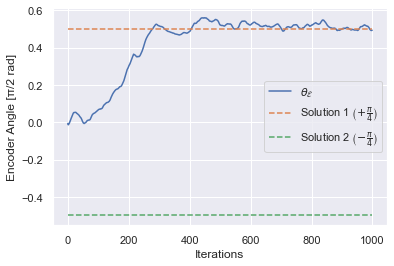

In [24]:
plot_theta(frames, gt_decoder.theta)

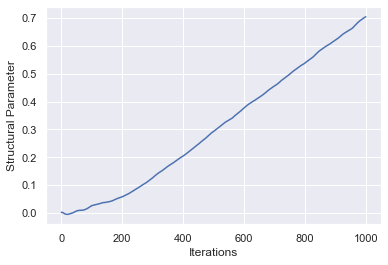

In [25]:
plot_key(frames, 'alpha', name='Structural Parameter')